# Final Analysis and Thermodynamics of Ising Model

I'm gonna do the actual data analysis on MC simulation for square lattice of $(L,L)$ dimension , for L that goes from $10$ to $70$ in steps of $5$, each simulation consists in $2*10^{6}$ calls of the $\verb|Metropolis()|$ function that does an update of the lattice ($L*L$ local updates). 
<br>
Measures are taken every $25$ MC steps

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.5*fig[1],
         'axes.labelsize': 2.8*fig[1],
         'axes.titlesize':4*fig[1],
         'xtick.labelsize':2*fig[1],
         'ytick.labelsize':2*fig[1],
         'font.family' : 'Stixgeneral'
          }
pylab.rcParams.update(params)


In [2]:
def getColor(c, N, idx):
    cmap=mpt.colormaps.get_cmap(c)
    norm = mpt.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

In [3]:
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)

In [4]:
files = np.arange(10,75,5)
for file in tqdm(files):
    filename = f"simulation_{file}.txt"
    bs, es, ms = np.loadtxt(filename, unpack=True)
    if (file==10):
        energy_mat = np.zeros((len(bs),len(files)+1))
        magnes_mat = np.zeros((len(bs),len(files)+1)) 

    energy_mat[:,int(file/5-2)] = es
    magnes_mat[:,int(file/5-2)] = ms

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
2000000/25 * len(beta_exp),len(bs)

In [ ]:
@jit
def data_asmatrix(files, beta_exp, energy_mat, magnes_mat):
    magns_L=np.zeros((len(beta_exp),len(files)))
    var_magns_L=np.zeros((len(beta_exp),len(files)))
    for i in range(0,len(files)):
        as_matrix = np.column_stack((bs,magnes_mat[:,i]))
        m=[]
        v=[]
        for b in (beta_exp):
            indices = as_matrix[:,0]
            mgns = np.sum(np.abs(as_matrix[(indices == b),1]))      # here one can 
            var=np.var(np.abs(as_matrix[(indices == b),1])[3000:])  # select the initial steps 
            mgns = mgns/(len(as_matrix[(indices == b),1]))          # which have to be neglected
            m.append(mgns)                                          #i.e. the point in the Markov-chain where to start averag, var ecc..
            v.append(var)
        magns_L[:,i]=m
        var_magns_L[:,i]=v
    return magns_L, var_magns_L

In [ ]:
%time magns_L, var_magns_L = data_asmatrix(files, beta_exp, energy_mat, magnes_mat)

In [ ]:
files = np.arange(10,75,5)
for file in files:
    plt.plot(beta_exp, magns_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.3',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))

plt.legend()    
plt.show()

In [ ]:
files = np.arange(10,75,5)
for file in files:
    i=int()
    plt.plot(beta_exp, var_magns_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.4',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))

plt.legend()    
plt.show()

In [ ]:
file=55
plt.plot(beta_exp, var_magns_L[:,int(file/5 - 2)],'+',markersize='5', linewidth='0.7',label=rf'{file}$ \times ${file}')

In [ ]:
#storie mc per grossi reticoli e grossi beta
as_matrix = np.column_stack((bs,magnes_mat[:,0]))
ind = as_matrix[:,0]
files=np.arange(50,75,5)
for file in files: plt.plot(np.abs(magnes_mat[ind==0.55,int(file/5 - 2)]),'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(((file-(files[0]-10)))/5 - 2)))

plt.legend()
plt.show()



In [ ]:
#storie mc per grossi reticoli e grossi beta
as_matrix = np.column_stack((bs,magnes_mat[:,0]))
ind = as_matrix[:,0]
files=np.arange(50,75,5)
for file in files: plt.plot(np.abs(magnes_mat[ind==0.54,int(file/5 - 2)]),'-.',markersize='9', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(((file-(files[0]-10)))/5 - 2)))
plt.xlim(-50,600)
plt.legend()
plt.show()


In [10]:
#NOw let's collect all the data both magnetization and energy and then calculate the susceptibility
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)
files = np.arange(10,75,5)
@njit
def data_asmatrix(files, beta_exp, energy_mat, magnes_mat):
    magns_L = np.zeros((len(beta_exp),len(files)))
    enes_L = np.zeros((len(beta_exp),len(files)))
    heatc_L = np.zeros((len(beta_exp),len(files)))
    chi_L = np.zeros((len(beta_exp),len(files)))
    #var_magns_L=np.zeros((len(beta_exp),len(files)))
    for file in files:
        i = int(file/5-2)
        as_matrix_m = np.column_stack((bs,magnes_mat[:,i]))
        as_matrix_e = np.column_stack((bs,energy_mat[:,i]))
        m,vm = [],[]
        e, ve = [],[]
        for b in (beta_exp):
            indices = as_matrix_m[:,0]
            Nm = len(as_matrix_m[(indices == b),1])
            Ne = len(as_matrix_e[(indices == b),1])
            mgns = np.sum(np.abs(as_matrix_m[(indices == b),1]))/Nm      
            enes = np.sum(as_matrix_e[(indices == b),1])/Ne 
            heat_c = (np.sum((as_matrix_e[(indices == b),1])**2)/Ne - (np.sum(as_matrix_e[(indices == b),1])/Ne)**2)*file**2
            chi = (np.sum((as_matrix_m[(indices == b),1])**2)/Nm - (np.sum(np.abs(as_matrix_m[(indices==b),1]))/Nm)**2)*file**2
            ve.append(heat_c)
            vm.append(chi)
            m.append(mgns)                                           
            e.append(enes)
                 
        magns_L[:,i] = m
        enes_L[:,i] = e
        heatc_L[:,i] = ve
        chi_L[:,i] = vm
        
                 
    return magns_L, enes_L, heatc_L, chi_L

In [11]:
%time magns_L, enes_L, heatc_L, chi_L = data_asmatrix(files, beta_exp, energy_mat, magnes_mat)

CPU times: user 2min 8s, sys: 11.4 s, total: 2min 19s
Wall time: 2min 19s


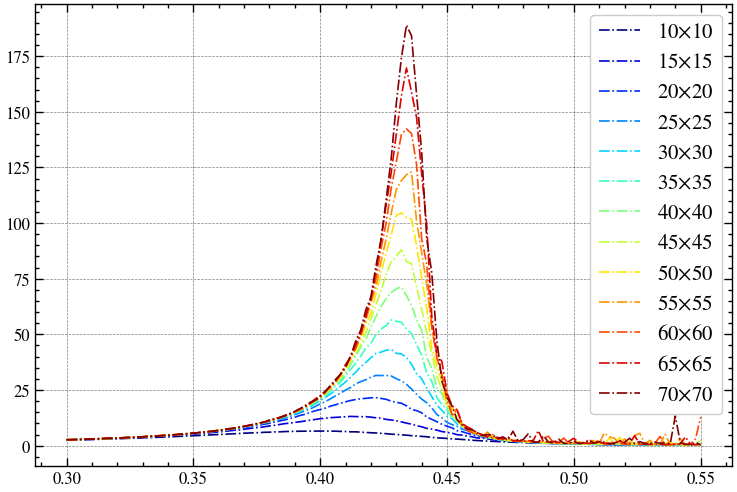

In [14]:
for file in files: 
    plt.plot(beta_exp, chi_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()
plt.show()

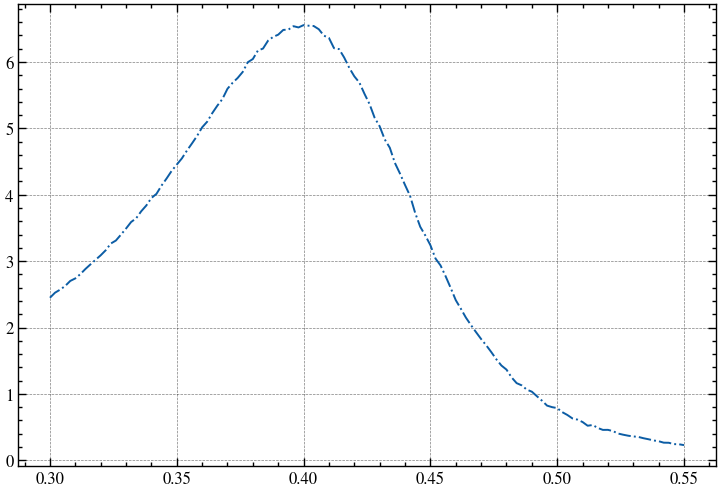

In [12]:
plt.plot(beta_exp, chi_L[:,0],'-.',markersize='6', linewidth='1.4',label=rf'10')


In [ ]:
def errori(files, beta_exp, energy_mat, magnes_mat):
    